# <font color='blue'>Agrupando Clientes Por Consumo de Energia</font>

In [26]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [27]:
# Carregando os dados
dataset = pd.read_csv('data/household_power_consumption.txt', delimiter = ';', low_memory = False)

In [28]:
dataset.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [29]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [33]:
# Removendo as colunas Date e Time
var = dataset.iloc[:,2:9]
dataset[var.columns] = var.astype(float)

In [34]:
# Verificando valores nulos
dataset.isnull().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [32]:
# Substituindo erros
dataset = dataset.replace('?',np.nan)

In [35]:
# Retirando valores nulos
dataset = dataset.dropna()
len(dataset)

2049280

In [36]:
# Coleta de uma amostra de 1% dos dados para criar o modelo de clusterização com o K-Means.
df = dataset.sample(frac=0.01, random_state=3666)
print(len(df))

20493


In [37]:
# Pré processamento dos dados
# Excluindo colunas Date e Time
df = df.drop(columns=['Date','Time'])

In [38]:
# Aplicar PCA para reduzir a dimensionalidade
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df)


In [39]:
# Encontrar o melhor valor de K
inercia=[]
for k in range(1,15):
    kmeans =KMeans(n_clusters=k, random_state=1604)
    kmeans.fit(df_pca)
    inercia.append(kmeans.inertia_)

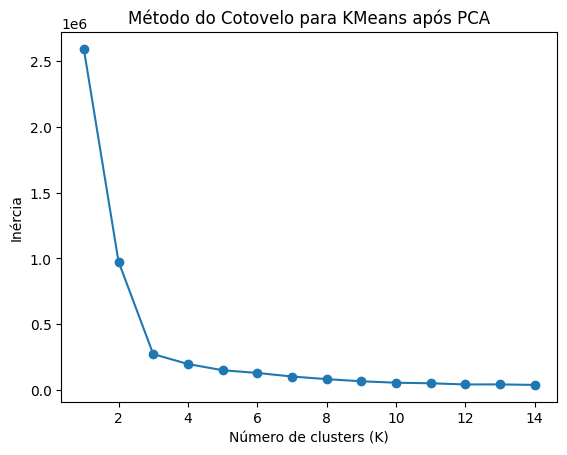

In [40]:
plt.plot(range(1,15), inercia, marker = 'o')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para KMeans após PCA')
plt.show()

In [41]:
# Criação o modelo K-Means usando o valor de K=8
modelo = KMeans(n_clusters=8).fit(df_pca)

In [42]:
x_min, x_max = df_pca[:, 0].min() - 5, df_pca[:, 0].max() - 1
y_min, y_max = df_pca[:, 1].min() + 1, df_pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

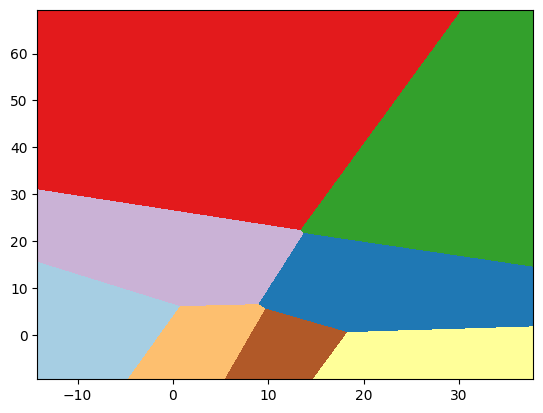

In [43]:
plt.figure(1)
plt.clf()
plt.imshow(Z, 
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto', 
           origin = 'lower')

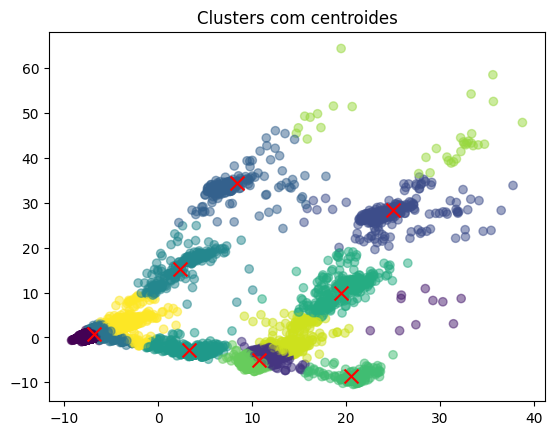

In [44]:
# Plotar os centroides
centroides= modelo.cluster_centers_
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=kmeans.labels_, alpha=0.5)
plt.scatter(centroides[:, 0], centroides[:, 1], marker='x', c='red', s=100)  # Plotar centroides
plt.title('Clusters com centroides')
plt.show()

In [45]:
labels = modelo.labels_

In [46]:
# Avaliando a performance do modelo
silhouette_score(df_pca,labels, metric='euclidean')

0.807727092949317

In [47]:
# Adicionando os resultados do cluster na df amostral
df_cluster = df
df_cluster['Cluster'] = labels
df_cluster.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Cluster
991420,0.338,0.056,241.81,1.4,0.0,0.0,0.0,0
1188438,0.220,0.000,247.58,0.8,0.0,0.0,0.0,0
1264730,0.494,0.234,244.23,2.2,0.0,2.0,1.0,0
1762709,2.098,0.400,241.29,8.8,0.0,0.0,29.0,6
2046198,1.460,0.166,236.66,6.2,0.0,1.0,1.0,0


In [48]:
# Avaliando o consumo médio de energia de cada cluster
df_cluster.groupby('Cluster')['Global_active_power'].mean()

Cluster
0    0.511714
1    3.780486
2    4.592936
3    3.544263
4    1.094240
5    2.613200
6    2.345829
7    1.806229
Name: Global_active_power, dtype: float64